In [1]:
!pip install zarr
!pip install -U xarray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/syde770/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
import os
import glob

# import import_ipynb
import pickle
import pandas as pd
import random
import numpy as np
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import tqdm

import seaborn as sns

from model_tester import ModelTester, masked_MAE, masked_MSE

In [5]:
# Read and drop unnecessary variables
zarr_path = 'data_full.zarr'

if 'google.colab' in sys.modules:
    zarr_path = '/content/drive/MyDrive/syde770/' + zarr_path

ds = xr.open_zarr(zarr_path)
ds = xr.concat([
    ds.sel(time=slice(None, datetime.datetime(2011, 9, 30))), 
    ds.sel(time=slice(datetime.datetime(2012, 10, 1), None))
    ], dim='time')
ds = ds.drop(['Lambert_Azimuthal_Grid', 'status_flag', 'ceda_sic_bin', 'era5_sic', 'era5_sic_bin', 'total_standard_error'])

# Specify loss
loss = masked_MSE

## Original tests

In [6]:
save_dir = 'model_data_2/'
model_names = [os.path.basename(fn.split('.')[0]) for fn in glob.glob(save_dir + '*.p') if not fn.endswith('model.p')]

model_tester = ModelTester()

results = []
for model_name in model_names:
    print(model_name)
    model_tester.load(model_name, save_dir)
    results.append(model_tester.df.loc['Test RMSE'])
    
df = pd.concat(results, axis=1)
df.columns = model_names
df = df.T


df = df.join(pd.DataFrame([n.split('_') for n in df.index], columns=['Scale', 'Timesteps', 'Gap', 'Model'], index=df.index))

df['Timesteps'] = [int(s[:-1]) for s in df.Timesteps]
df['Gap'] = [int(s[:-1]) for s in df.Gap]
df['Model'] = pd.Categorical(df['Model'], ['Extra-light', 'Light', 'Medium', 'Heavy', 'Extra-heavy'])

df = df.sort_values(['Timesteps', 'Gap', 'Model'])

df = df[df.Model != 'Extra-heavy']  # Remove extra heavy models. Not good and take too long to run.

# Threshold for RMSE over baseline to be considered not converged
thresh = 0.75
df = df[(df.NN - df[['Persistence', 'Climatology']].min(axis=1)) < thresh]

df

Daily_14T_14G_Extra-light
Daily_14T_14G_Light
Daily_14T_14G_Medium
Daily_14T_14G_Heavy
Daily_7T_14G_Extra-light
Daily_7T_14G_Light
Daily_7T_14G_Medium
Daily_7T_14G_Heavy
Daily_3T_14G_Extra-light
Daily_3T_14G_Light
Daily_3T_14G_Medium
Daily_3T_14G_Heavy
Daily_14T_7G_Extra-light
Daily_14T_7G_Light
Daily_14T_7G_Medium
Daily_14T_7G_Heavy
Daily_7T_7G_Extra-light
Daily_7T_7G_Light
Daily_7T_7G_Medium
Daily_7T_7G_Heavy
Daily_3T_7G_Extra-light
Daily_3T_7G_Light
Daily_3T_7G_Medium
Daily_3T_7G_Heavy
Daily_14T_0G_Extra-light
Daily_14T_0G_Light
Daily_14T_0G_Medium
Daily_14T_0G_Heavy
Daily_7T_0G_Extra-light
Daily_7T_0G_Light
Daily_7T_0G_Medium
Daily_7T_0G_Heavy
Daily_3T_0G_Extra-light
Daily_3T_0G_Light
Daily_3T_0G_Medium
Daily_3T_0G_Heavy
Weekly_8T_2G_Extra-light
Weekly_8T_2G_Light
Weekly_8T_2G_Medium
Weekly_8T_2G_Heavy
Weekly_4T_2G_Extra-light
Weekly_4T_2G_Light
Weekly_4T_2G_Medium
Weekly_4T_2G_Heavy
Weekly_8T_0G_Extra-light
Weekly_8T_0G_Light
Weekly_8T_0G_Medium
Weekly_8T_0G_Heavy
Weekly_4T_0G_Ext

,NN,Persistence,Climatology,Scale,Timesteps,Gap,Model
Daily_3T_0G_Extra-light,3.681276,3.857197,6.364280,Daily,3,0,Extra-light
Daily_3T_0G_Light,3.642764,3.857197,6.364280,Daily,3,0,Light
Daily_3T_0G_Medium,3.798293,3.857197,6.364280,Daily,3,0,Medium
Daily_3T_0G_Heavy,3.925237,3.857197,6.364280,Daily,3,0,Heavy
Daily_3T_7G_Extra-light,3.749944,3.857197,6.364280,Daily,3,7,Extra-light
Daily_3T_7G_Light,3.654564,3.857197,6.364280,Daily,3,7,Light
Daily_3T_7G_Medium,3.817962,3.857197,6.364280,Daily,3,7,Medium
Daily_3T_7G_Heavy,3.795583,3.857197,6.364280,Daily,3,7,Heavy
Daily_3T_14G_Extra-light,3.629594,3.857197,6.364280,Daily,3,14,Extra-light
Daily_3T_14G_Light,3.732244,3.857197,6.364280,Daily,3,14,Light


In [ ]:
# Daily_3T_0G_Heavy @ 53, 54 9test) good example 

m = ModelTester()
m.load('Daily_3T_7G_Heavy', save_dir, load_model=True)
# del m.data_params['ds']
m.preprocess_data(ds, **m.data_params)

FileNotFoundError: [Errno 2] No such file or directory: 'save_dir_3/Daily_3T_7G_Heavy.p'

2022-04-06 15:58:38.510673: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-06 15:58:38.879848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


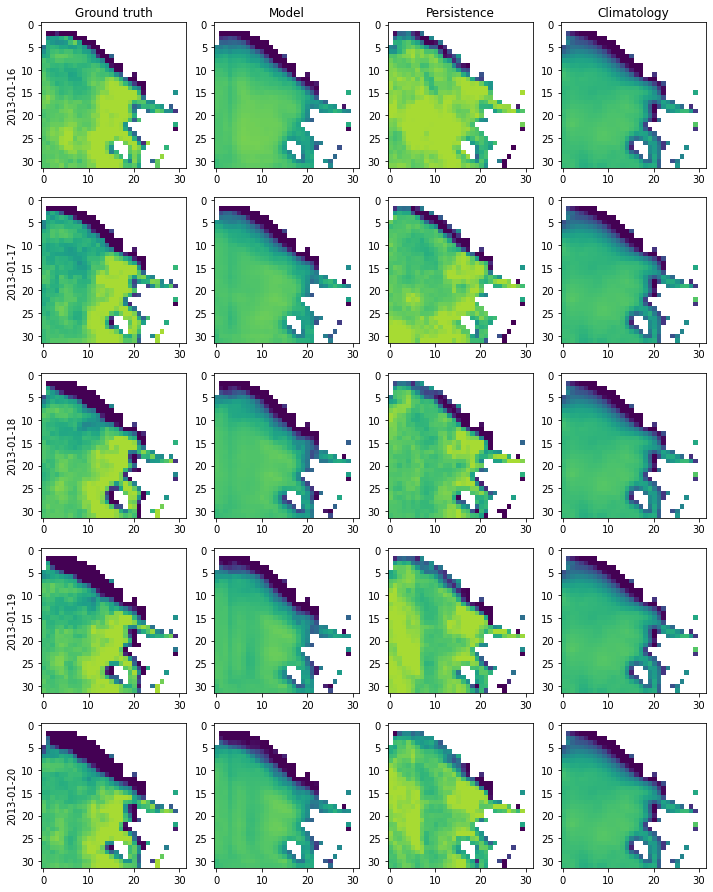

In [ ]:
fig, axs = m.plot_examples(5, 44, set_='test')

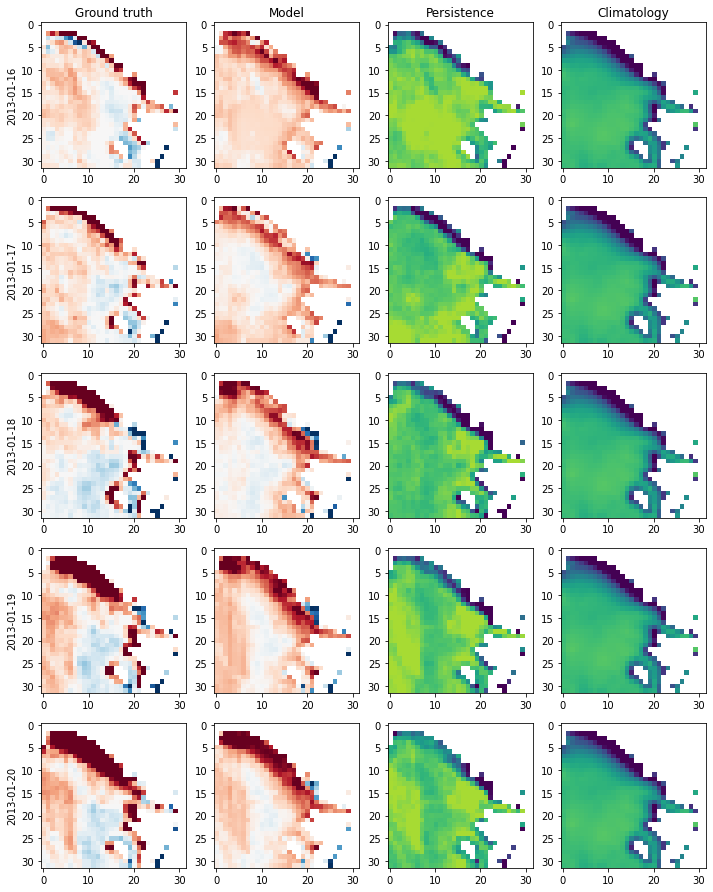

In [ ]:
fig, axs = m.plot_examples(5, 44, set_='test', diff_from='Persistence')

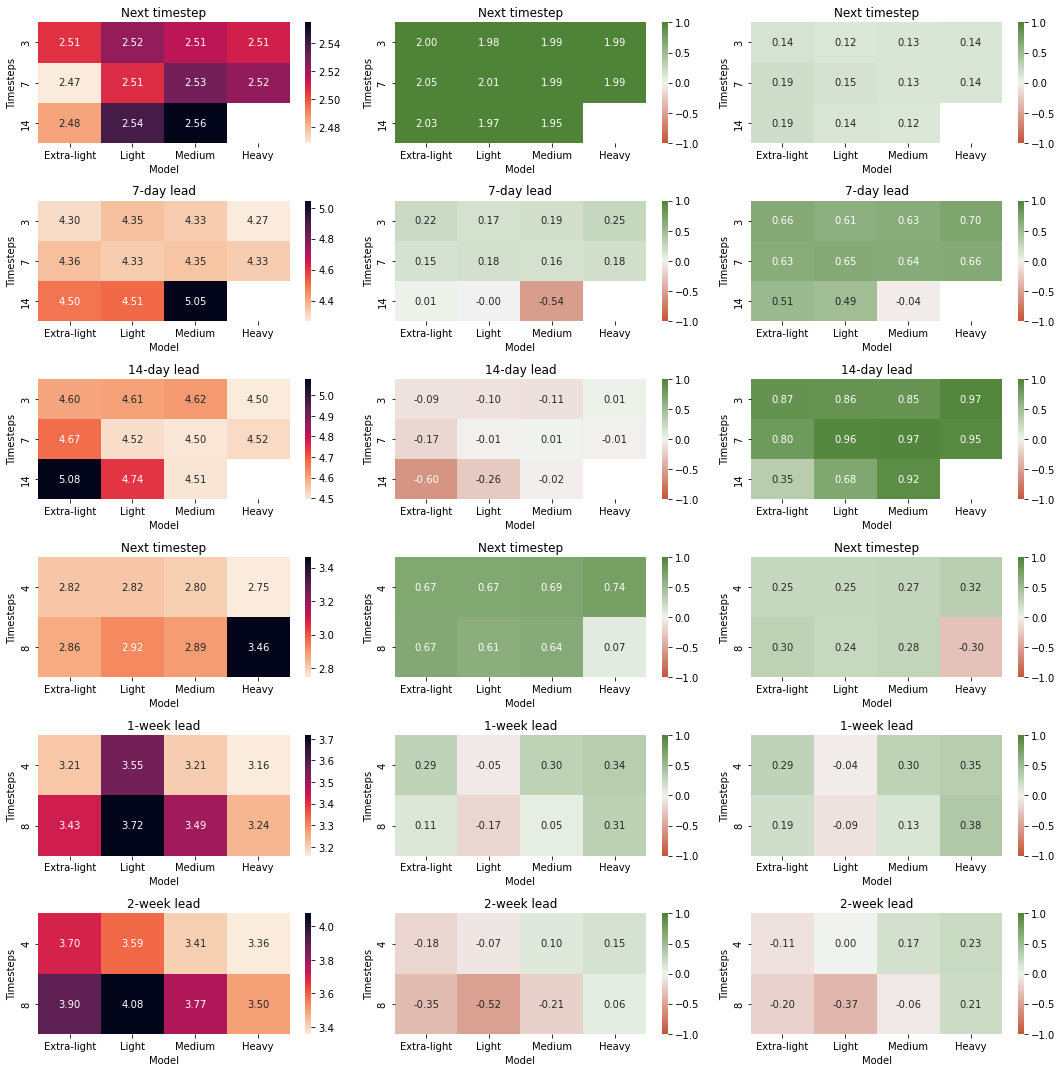

In [ ]:
fig, axs = plt.subplots(6, 3, figsize=(15, 15))


cmap = sns.diverging_palette(20, 120, as_cmap=True)

# Plot raw RMSE
for i, (experiment_type, tmp) in enumerate(df.groupby(['Scale', 'Gap'])):
    # Raw RMSE
    raw_rmse = tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(raw_rmse,
                annot=True, 
                cmap='rocket_r',
                ax=axs[i][0],
                fmt='.2f')
    
    # Diff (Climatology)
    diff = tmp.pivot(values='Climatology', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[i][1],
                fmt='.2f')
    
    # Diff (Persistence)
    diff = tmp.pivot(values='Persistence', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[i][2],
                fmt='.2f')
    
    # Set titles
    for j in range(3):
        if experiment_type[1] == 0:
            axs[i][j].set_title(f'Next timestep')
        elif experiment_type[0] == 'Daily':
            axs[i][j].set_title(f'{experiment_type[1]}-day lead')
        else:
            axs[i][j].set_title(f'{experiment_type[1]}-week lead')

plt.tight_layout()

<AxesSubplot:>

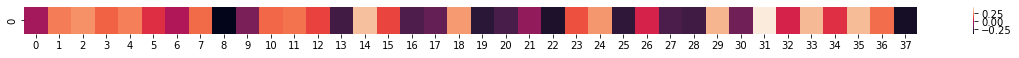

In [ ]:
plt.figure(figsize=(20, 0.5))
sns.heatmap(m.model.layers[-1].weights[0][0, :, :, 0].numpy())

## Sensitivity Analysis

In [ ]:
def shuffle_ndarray(arr):
    arr_shape = arr.shape

    arr = arr.flatten()
    random.shuffle(arr)
    return arr.reshape(arr_shape)

def shuffle_along_dim(arr, i, axis=0):
    arr_i = shuffle_ndarray(np.moveaxis(arr, axis, 0)[i])
    arr = np.moveaxis(arr, axis, 0)
    arr[i] = arr_i
    arr = np.moveaxis(arr, 0, axis)
    return arr

var_list = ['sic', 'sshf', 'sst', 't2m', 'u10', 'v10']

frame = 215

fig, axs = plt.subplots(6, 6, figsize=(15, 15))
for j, _ in enumerate(var_list):
    test_X = shuffle_along_dim(m.test_X.copy(), j, axis=-1)
    
    for i, var_name in enumerate(var_list):
        axs[j][i].imshow(test_X[frame, -1, :, :, i])
        axs[j][i].set_title(var_name)

In [ ]:
rmses_by_model = {}

model_names = ['Daily_14T_0G_Extra-light',
                'Daily_3T_7G_Heavy',
                'Weekly_4T_0G_Heavy',
                'Weekly_8T_1G_Heavy',
                'Weekly_4T_2G_Heavy']
for model_name in model_names:
    model_tester = ModelTester()
    model_tester.load(model_name, save_dir, load_model=True)
    print(model_name)

    del model_tester.data_params['ds']
    model_tester.preprocess_data(ds, **model_tester.data_params)

    # List of test_X where each variable is shuffled 
    rmses = []
    for i in tqdm.tqdm(range(10)):
        test_X_shuffled = [shuffle_along_dim(model_tester.test_X.copy(), i, axis=-1) for i in range(6)]

        # Test each one
        rmses_i = []
        for test_X in [model_tester.test_X] + test_X_shuffled:
            pred = model_tester.model.predict(test_X)
            nan_mask_reshaped = np.expand_dims(~model_tester.nan_mask, [0, -1])

            mse = masked_MSE(nan_mask_reshaped)(
                model_tester.inverse_sic(model_tester.test_Y),
                model_tester.inverse_sic(pred)).numpy()
            rmses_i.append(np.sqrt(mse))

        rmses.append(rmses_i)

    rmses = np.array(rmses).mean(axis=0)
    
    print(rmses)
    
    rmses_by_model[model_name] = rmses

Daily_14T_0G_Extra-light


100%|███████████████████████████████████████████| 10/10 [08:07<00:00, 48.76s/it]


[2.48416941 6.30936426 2.48407    2.4839952  2.49801962 2.49073324
 2.4899597 ]
Daily_3T_7G_Heavy


100%|██████████████████████████████████████████| 10/10 [30:12<00:00, 181.23s/it]


[4.26776156 5.69992405 4.26776156 4.26776156 4.26776156 4.26776156
 4.26776156]
Weekly_4T_0G_Heavy


/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
100%|███████████████████████████████████████████| 10/10 [06:38<00:00, 39.83s/it]


[2.74561167 4.72874809 2.74561167 2.74561167 2.74561167 2.74561167
 2.74561167]
Weekly_8T_1G_Heavy


/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
100%|███████████████████████████████████████████| 10/10 [15:46<00:00, 94.61s/it]


[3.23735378 4.62612856 3.23735378 3.23735378 3.23752467 3.23735659
 3.23744683]
Weekly_4T_2G_Heavy


/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
100%|███████████████████████████████████████████| 10/10 [07:04<00:00, 42.43s/it]


[3.3584989  4.48412624 3.3584989  3.3584989  3.3584989  3.3584989
 3.3584989 ]


In [14]:
model_tester.__dict__.keys()

dict_keys(['data_params', 'model_params', 'num_timesteps', 'binary_sic', 'nan_mask', 'scaler', 'train_Y', 'train_X', 'test_Y', 'test_X', 'dates_train', 'dates_test', 'input_shape', 'history', 'df', 'model'])

In [9]:
model_name

'model_data/Weekly_4T_0G_Medium'

In [13]:
model_names = [f[:-2] for f in glob.glob('save_dir*/*.p') if not f.endswith('model.p')]
for model_name in model_names:
    model_tester = ModelTester()
    model_tester.load(model_name, '', load_model=False)
    del model_tester.train_X
    del model_tester.test_X
    model_tester.save(model_name, '')

In [ ]:
pd.DataFrame({
    model_name: [(rmse - rmses[0]).round(3) for rmse in rmses[1:]] for model_name, rmses in rmses_by_model.items()
}, index=var_list).T

,sic,sshf,sst,t2m,u10,v10
Daily_14T_0G_Extra-light,3.825,-0.0,-0.0,0.014,0.007,0.006
Daily_3T_7G_Heavy,1.432,0.0,0.0,0.000,0.000,0.000
Weekly_4T_0G_Heavy,1.983,0.0,0.0,0.000,0.000,0.000
Weekly_8T_1G_Heavy,1.389,0.0,0.0,0.000,0.000,0.000
Weekly_4T_2G_Heavy,1.126,0.0,0.0,0.000,0.000,0.000


## Test

In [ ]:
save_dir = 'save_dir_5/'
model_names = [os.path.basename(fn.split('.')[0]) for fn in glob.glob(save_dir + '*.p') if not fn.endswith('model.p')]

model_tester = ModelTester()

results = []
for model_name in model_names:
    print(model_name)
    model_tester.load(model_name, save_dir, load_model=False)
    # model_tester.preprocess_data(ds, **model_tester.data_params)
    # model_tester.get_results()
    results.append(model_tester.df.loc['Test RMSE'])
    
df = pd.concat(results, axis=1)
df.columns = model_names
df = df.T


df = df.join(pd.DataFrame([n.split('_') for n in df.index], columns=['Scale', 'Timesteps', 'Gap', 'Model'], index=df.index))

df['Timesteps'] = [int(s[:-1]) for s in df.Timesteps]
df['Gap'] = [int(s[:-1]) for s in df.Gap]
df['Model'] = pd.Categorical(df['Model'], ['Extra-light', 'Light', 'Medium', 'Heavy', 'Extra-heavy'])

df = df.sort_values(['Scale', 'Gap', 'Timesteps', 'Model'])

df = df[df.Model != 'Extra-heavy']  # Remove extra heavy models. Not good and take too long to run.

# Threshold for RMSE over baseline to be considered not converged
thresh = 0.75
df = df[(df.NN - df[['Persistence', 'Climatology']].min(axis=1)) < thresh]

df

Weekly_4T_0G_Heavy
Weekly_4T_0G_Medium
Weekly_4T_0G_Light
Weekly_4T_0G_Extra-light
Weekly_8T_2G_Extra-light
Weekly_8T_2G_Light
Weekly_8T_2G_Medium
Weekly_8T_2G_Heavy
Weekly_4T_2G_Extra-light
Weekly_4T_2G_Light
Weekly_4T_2G_Medium
Weekly_4T_2G_Heavy
Weekly_8T_0G_Extra-light
Weekly_8T_0G_Light
Weekly_8T_0G_Medium
Weekly_8T_0G_Heavy
Daily_3T_0G_Heavy
Daily_3T_0G_Extra-light
Daily_3T_0G_Light
Daily_3T_0G_Medium
Daily_7T_0G_Heavy
Daily_7T_0G_Medium
Daily_7T_0G_Extra-light
Daily_7T_0G_Light
Daily_3T_7G_Heavy
Daily_3T_7G_Medium
Daily_3T_7G_Light
Daily_3T_7G_Extra-light
Daily_7T_7G_Heavy
Daily_7T_7G_Medium
Daily_7T_7G_Light
Daily_7T_7G_Extra-light
Daily_3T_14G_Extra-light
Daily_3T_14G_Light
Daily_3T_14G_Medium
Daily_3T_14G_Heavy
Daily_7T_14G_Heavy
Daily_7T_14G_Extra-light
Daily_7T_14G_Light
Daily_7T_14G_Medium


,NN,Persistence,Climatology,Scale,Timesteps,Gap,Model
Daily_3T_0G_Extra-light,3.512297,11.865215,3.528191,Daily,3,0,Extra-light
Daily_3T_0G_Light,3.567764,11.865215,3.528191,Daily,3,0,Light
Daily_3T_0G_Medium,3.543986,11.865215,3.528191,Daily,3,0,Medium
Daily_3T_0G_Heavy,3.626981,11.865215,3.528191,Daily,3,0,Heavy
Daily_7T_0G_Extra-light,3.501855,11.910030,3.547007,Daily,7,0,Extra-light
Daily_7T_0G_Light,3.670749,11.910030,3.547007,Daily,7,0,Light
Daily_7T_0G_Medium,3.644978,11.910030,3.547007,Daily,7,0,Medium
Daily_7T_0G_Heavy,3.643065,11.910030,3.547007,Daily,7,0,Heavy
Daily_3T_7G_Extra-light,3.559007,11.267432,3.557594,Daily,3,7,Extra-light
Daily_3T_7G_Light,3.558999,11.267432,3.557594,Daily,3,7,Light


In [ ]:
model_tester = ModelTester()
model_tester.load('Weekly_4T_2G_Medium', 'save_dir_4/', load_model=True)
model_tester.preprocess_data(ds, **m.data_params)

/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/Zach/miniforge3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(150, 1, 32, 32, 6)
(150, 1, 32, 32, 6)


In [ ]:
rmses = []
for i in tqdm.tqdm(range(3)):
    test_X_shuffled = [shuffle_along_dim(model_tester.test_X.copy(), i, axis=-1) for i in range(6)]

    # Test each one
    rmses_i = []
    for test_X in [model_tester.test_X] + test_X_shuffled:
        pred = model_tester.model.predict(test_X)
        nan_mask_reshaped = np.expand_dims(~model_tester.nan_mask, [0, -1])

        mse = masked_MSE(nan_mask_reshaped)(
            model_tester.inverse_sic(model_tester.test_Y),
            model_tester.inverse_sic(pred)).numpy()
        rmses_i.append(np.sqrt(mse))

    rmses.append(rmses_i)

rmses = np.array(rmses).mean(axis=0)

print(rmses)

100%|█████████████████████████████████████████████| 3/3 [00:45<00:00, 15.24s/it]


[3.4314293  3.50226928 3.4314293  3.4314293  3.4314293  3.4314293
 3.4314293 ]


## Change convolution

In [ ]:
model_names = [os.path.basename(fn.split('.')[0]) for fn in glob.glob(save_dir + '*.p') if not fn.endswith('model.p')]

model_tester = ModelTester()

results = []
for model_name in model_names:
    print(model_name)
    model_tester.load(model_name, save_dir)
    results.append(model_tester.df.loc['Test RMSE'])
    
df = pd.concat(results, axis=1)
df.columns = model_names
df = df.T


df = df.join(pd.DataFrame([n.split('_') for n in df.index], columns=['Scale', 'Timesteps', 'Gap', 'Model'], index=df.index))

df['Timesteps'] = [int(s[:-1]) for s in df.Timesteps]
df['Gap'] = [int(s[:-1]) for s in df.Gap]
df['Model'] = pd.Categorical(df['Model'], ['Extra-light-conv', 'Light-conv', 'Medium-conv', 'Heavy-conv', 'Extra-heavy-conv'])

df = df.sort_values(['Timesteps', 'Gap', 'Model'])

df = df[df.Model != 'Extra-heavy']  # Remove extra heavy models. Not good and take too long to run.

# Threshold for RMSE over baseline to be considered not converged
thresh = 0.75
df = df[(df.NN - df[['Persistence', 'Climatology']].min(axis=1)) < thresh]

df

Daily_7T_7G_Light-conv
Daily_7T_7G_Medium-conv
Daily_7T_7G_Heavy-conv
Daily_3T_7G_Light-conv
Daily_3T_7G_Medium-conv
Daily_3T_7G_Heavy-conv
Daily_7T_0G_Light-conv
Daily_7T_0G_Medium-conv
Daily_7T_0G_Heavy-conv
Daily_3T_0G_Light-conv
Daily_3T_0G_Medium-conv
Daily_3T_0G_Heavy-conv
Weekly_8T_2G_Light-conv
Weekly_8T_2G_Medium-conv
Weekly_8T_2G_Heavy-conv
Weekly_4T_2G_Light-conv
Weekly_4T_2G_Medium-conv
Weekly_4T_2G_Heavy-conv
Weekly_8T_0G_Light-conv
Weekly_8T_0G_Medium-conv
Weekly_8T_0G_Heavy-conv
Weekly_4T_0G_Light-conv
Weekly_4T_0G_Medium-conv
Weekly_4T_0G_Heavy-conv


,NN,Persistence,Climatology,Scale,Timesteps,Gap,Model
Daily_3T_0G_Light-conv,2.494011,2.646632,4.501807,Daily,3,0,Light-conv
Daily_3T_0G_Medium-conv,2.561930,2.646632,4.501807,Daily,3,0,Medium-conv
Daily_3T_0G_Heavy-conv,2.497827,2.646632,4.501807,Daily,3,0,Heavy-conv
Daily_3T_7G_Light-conv,2.506732,2.646632,4.501807,Daily,3,7,Light-conv
Daily_3T_7G_Medium-conv,2.492006,2.646632,4.501807,Daily,3,7,Medium-conv
Daily_3T_7G_Heavy-conv,2.506718,2.646632,4.501807,Daily,3,7,Heavy-conv
Weekly_4T_0G_Light-conv,2.921963,3.068237,3.490464,Weekly,4,0,Light-conv
Weekly_4T_0G_Medium-conv,2.953986,3.068237,3.490464,Weekly,4,0,Medium-conv
Weekly_4T_0G_Heavy-conv,2.789357,3.068237,3.490464,Weekly,4,0,Heavy-conv
Weekly_4T_2G_Light-conv,3.666409,3.587233,3.513167,Weekly,4,2,Light-conv


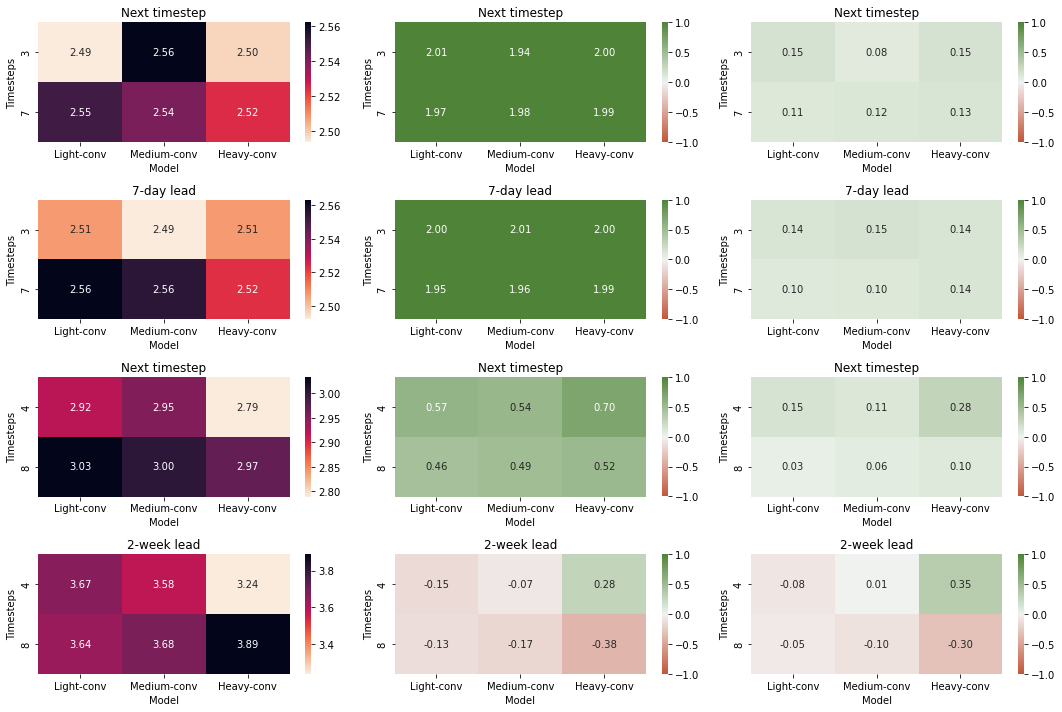

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))


cmap = sns.diverging_palette(20, 120, as_cmap=True)

# Plot raw RMSE
for i, (experiment_type, tmp) in enumerate(df.groupby(['Scale', 'Gap'])):
    # Raw RMSE
    raw_rmse = tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(raw_rmse,
                annot=True, 
                cmap='rocket_r',
                ax=axs[i][0],
                fmt='.2f')
    
    # Diff (Climatology)
    diff = tmp.pivot(values='Climatology', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[i][1],
                fmt='.2f')
    
    # Diff (Persistence)
    diff = tmp.pivot(values='Persistence', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[i][2],
                fmt='.2f')
    
    # Set titles
    for j in range(3):
        if experiment_type[1] == 0:
            axs[i][j].set_title(f'Next timestep')
        elif experiment_type[0] == 'Daily':
            axs[i][j].set_title(f'{experiment_type[1]}-day lead')
        else:
            axs[i][j].set_title(f'{experiment_type[1]}-week lead')
    
plt.tight_layout()

## Lights!

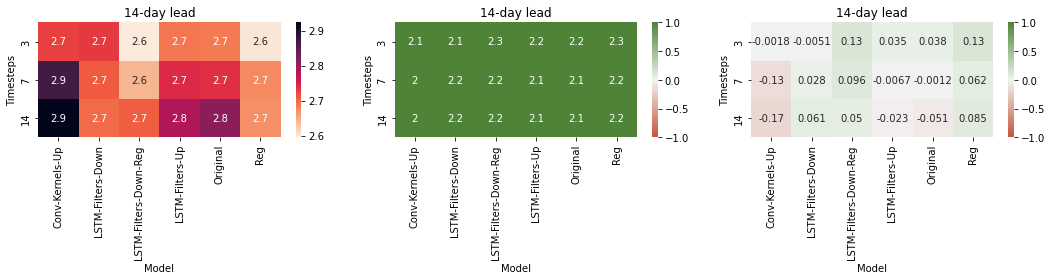

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))


cmap = sns.diverging_palette(20, 120, as_cmap=True)

# Plot raw RMSE
for i, (experiment_type, tmp) in enumerate(df.groupby(['Scale', 'Gap'])):
    # Raw RMSE
    raw_rmse = tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(raw_rmse,
                annot=True, 
                cmap='rocket_r',
                ax=axs[0])
    
    # Diff (Climatology)
    diff = tmp.pivot(values='Climatology', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[1])
    
    # Diff (Persistence)
    diff = tmp.pivot(values='Persistence', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[2])
    
    # Set titles
    for j in range(3):
        if experiment_type[1] == 0:
            axs[j].set_title(f'Next timestep')
        elif experiment_type[0] == 'Daily':
            axs[j].set_title(f'{experiment_type[1]}-day lead')
        else:
            axs[j].set_title(f'{experiment_type[1]}-week lead')
    
plt.tight_layout()

In [ ]:
model_tester = ModelTester()
model_tester.load('Daily_3T_14G_LSTM-Filters-Down-Reg', save_dir)

model_tester.df

,NN,Persistence,Climatology
Train MAE,1.523509,1.586433,3.145647
Train RMSE,3.088362,3.471654,5.592796
Test MAE,1.224489,1.130017,2.905655
Test RMSE,2.594886,2.724922,4.853332


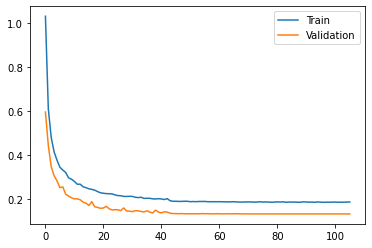

In [ ]:
plt.plot(model_tester.history['loss'], label='Train')
plt.plot(model_tester.history['val_loss'], label='Validation')
plt.legend()

In [ ]:
model_tester = ModelTester()
model_name = 'Daily_3T_14G_LSTM-Filters-Down-Reg'
print(model_name)

model_tester.load(model_name, 'model_data_lights/', load_model=True)

# List of test_X where each variable is shuffled 
rmses = []
for i in tqdm.tqdm(range(20)):
    test_X_shuffled = [shuffle_along_dim(model_tester.test_X.copy(), i, axis=-1) for i in range(6)]

    # Test each one
    rmses_i = []
    for test_X in [model_tester.test_X] + test_X_shuffled:
        pred = model_tester.model.predict(test_X)
        nan_mask_reshaped = np.expand_dims(~model_tester.nan_mask, [0, -1])

        mse = masked_MSE(nan_mask_reshaped)(
            model_tester.inverse_sic(model_tester.test_Y),
            model_tester.inverse_sic(pred)).numpy()
        rmses_i.append(np.sqrt(mse))

    rmses.append(rmses_i)

rmses = np.array(rmses).mean(axis=0)

Daily_3T_14G_LSTM-Filters-Down-Reg


100%|███████████████████████████████████████████| 20/20 [03:38<00:00, 10.90s/it]


In [ ]:
var_list = ['sic', 'sshf', 'sst', 't2m', 'u10', 'v10']
diff = [rmse - rmses[0] for rmse in rmses]
pd.DataFrame(diff[1:], index=var_list, columns=['Impact on RMSE after removal']).round(2)

,Impact on RMSE after removal
sic,3.91
sshf,0.01
sst,-0.00
t2m,0.03
u10,0.00
v10,-0.00


## Light model larger area

In [ ]:
save_dir = 'model_data_lights_larger_area/'
model_names = [os.path.basename(fn.split('.')[0]) for fn in glob.glob(save_dir + '*.p') if not fn.endswith('model.p')]

model_tester = ModelTester()

results = []
for model_name in model_names:
    print(model_name)
    model_tester.load(model_name, save_dir)
    results.append(model_tester.df.loc['Test RMSE'])
    
df = pd.concat(results, axis=1)
df.columns = model_names
df = df.T

df = df.reset_index(drop=True).join(pd.DataFrame([n.split('_') for n in df.index], columns=['Scale', 'Timesteps', 'Gap', 'Model']))

df['Timesteps'] = [int(s[:-1]) for s in df.Timesteps]
df['Gap'] = [int(s[:-1]) for s in df.Gap]
df = df.sort_values(['Timesteps', 'Gap'])

df

Daily_14T_14G_LSTM-Filters-Down-Reg
Daily_14T_14G_Reg
Daily_14T_14G_Conv-Kernels-Up
Daily_14T_14G_LSTM-Filters-Up
Daily_14T_14G_LSTM-Filters-Down
Daily_14T_14G_Original
Daily_7T_14G_LSTM-Filters-Down-Reg
Daily_7T_14G_Reg
Daily_7T_14G_Conv-Kernels-Up
Daily_7T_14G_LSTM-Filters-Up
Daily_7T_14G_LSTM-Filters-Down
Daily_7T_14G_Original
Daily_3T_14G_LSTM-Filters-Down-Reg
Daily_3T_14G_Reg
Daily_3T_14G_Original
Daily_3T_14G_LSTM-Filters-Down
Daily_3T_14G_LSTM-Filters-Up
Daily_3T_14G_Conv-Kernels-Up


,NN,Persistence,Climatology,Scale,Timesteps,Gap,Model
12,2.161497,2.291044,4.096077,Daily,3,14,LSTM-Filters-Down-Reg
13,2.191819,2.291044,4.096077,Daily,3,14,Reg
14,2.335874,2.291044,4.096077,Daily,3,14,Original
15,2.257260,2.291044,4.096077,Daily,3,14,LSTM-Filters-Down
16,2.275776,2.291044,4.096077,Daily,3,14,LSTM-Filters-Up
17,2.339685,2.291044,4.096077,Daily,3,14,Conv-Kernels-Up
6,2.212421,2.300691,4.104960,Daily,7,14,LSTM-Filters-Down-Reg
7,2.231762,2.300691,4.104960,Daily,7,14,Reg
8,2.418263,2.300691,4.104960,Daily,7,14,Conv-Kernels-Up
9,2.342141,2.300691,4.104960,Daily,7,14,LSTM-Filters-Up


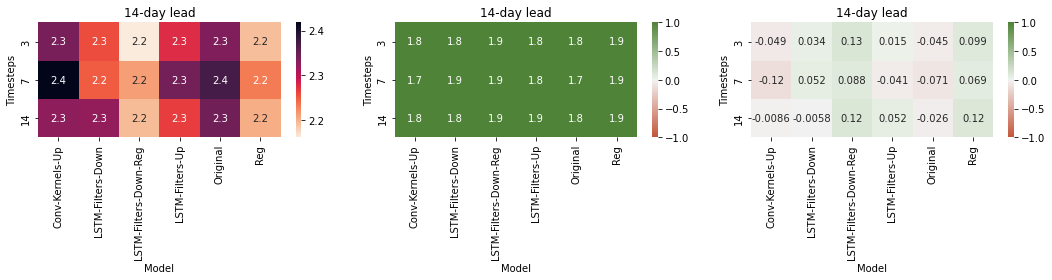

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))


cmap = sns.diverging_palette(20, 120, as_cmap=True)

# Plot raw RMSE
for i, (experiment_type, tmp) in enumerate(df.groupby(['Scale', 'Gap'])):
    # Raw RMSE
    raw_rmse = tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(raw_rmse,
                annot=True, 
                cmap='rocket_r',
                ax=axs[0])
    
    # Diff (Climatology)
    diff = tmp.pivot(values='Climatology', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[1])
    
    # Diff (Persistence)
    diff = tmp.pivot(values='Persistence', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[2])
    
    # Set titles
    for j in range(3):
        if experiment_type[1] == 0:
            axs[j].set_title(f'Next timestep')
        elif experiment_type[0] == 'Daily':
            axs[j].set_title(f'{experiment_type[1]}-day lead')
        else:
            axs[j].set_title(f'{experiment_type[1]}-week lead')
    
plt.tight_layout()

## Light model larger area without SIC as input, and all variables appended as last day

In [ ]:
save_dir = 'model_data_lights_larger_area_append/'
model_names = [os.path.basename(fn.split('.')[0]) for fn in glob.glob(save_dir + '*.p') if not fn.endswith('model.p')]

model_tester = ModelTester()

results = []
for model_name in model_names:
    print(model_name)
    model_tester.load(model_name, save_dir)
    results.append(model_tester.df.loc['Test MAE'])
    
df = pd.concat(results, axis=1)
df.columns = model_names
df = df.T

df = df.reset_index(drop=True).join(pd.DataFrame([n.split('_') for n in df.index], columns=['Scale', 'Timesteps', 'Gap', 'Model']))

df['Timesteps'] = [int(s[:-1]) for s in df.Timesteps]
df['Gap'] = [int(s[:-1]) for s in df.Gap]
df = df.sort_values(['Timesteps', 'Gap'])

df

Daily_3T_14G_Original
Daily_3T_14G_LSTM-Filters-Down
Daily_3T_14G_LSTM-Filters-Up
Daily_3T_14G_Conv-Kernels-Up
Daily_3T_14G_Reg
Daily_3T_14G_LSTM-Filters-Down-Reg
Daily_7T_14G_Original
Daily_7T_14G_LSTM-Filters-Down
Daily_7T_14G_LSTM-Filters-Up
Daily_7T_14G_Conv-Kernels-Up
Daily_7T_14G_Reg
Daily_7T_14G_LSTM-Filters-Down-Reg
Daily_14T_14G_Original
Daily_14T_14G_LSTM-Filters-Up
Daily_14T_14G_LSTM-Filters-Down
Daily_14T_14G_Conv-Kernels-Up
Daily_14T_14G_Reg
Daily_14T_14G_LSTM-Filters-Down-Reg


,NN,Persistence,Climatology,Scale,Timesteps,Gap,Model
0,1.067065,0.788988,2.019659,Daily,3,14,Original
1,0.948242,0.788988,2.019659,Daily,3,14,LSTM-Filters-Down
2,1.124826,0.788988,2.019659,Daily,3,14,LSTM-Filters-Up
3,1.068453,0.788988,2.019659,Daily,3,14,Conv-Kernels-Up
4,0.881771,0.788988,2.019659,Daily,3,14,Reg
5,0.862764,0.788988,2.019659,Daily,3,14,LSTM-Filters-Down-Reg
6,1.041397,0.795646,2.022147,Daily,7,14,Original
7,0.984834,0.795646,2.022147,Daily,7,14,LSTM-Filters-Down
8,1.243401,0.795646,2.022147,Daily,7,14,LSTM-Filters-Up
9,1.227780,0.795646,2.022147,Daily,7,14,Conv-Kernels-Up


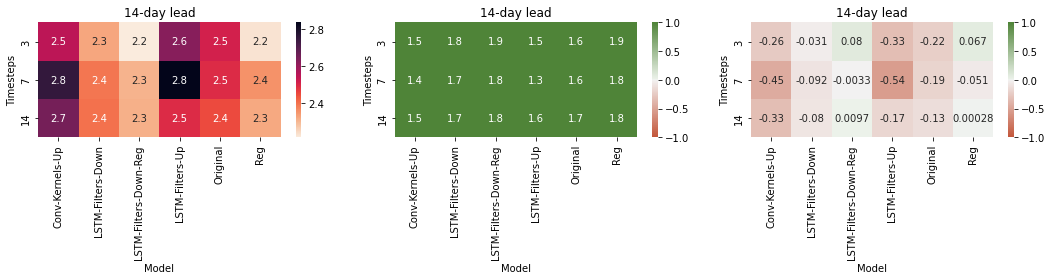

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))


cmap = sns.diverging_palette(20, 120, as_cmap=True)

# Plot raw RMSE
for i, (experiment_type, tmp) in enumerate(df.groupby(['Scale', 'Gap'])):
    # Raw RMSE
    raw_rmse = tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(raw_rmse,
                annot=True, 
                cmap='rocket_r',
                ax=axs[0])
    
    # Diff (Climatology)
    diff = tmp.pivot(values='Climatology', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[1])
    
    # Diff (Persistence)
    diff = tmp.pivot(values='Persistence', columns='Model', index='Timesteps') - \
                tmp.pivot(values='NN', columns='Model', index='Timesteps')
    sns.heatmap(diff,
                annot=True,
                cmap=cmap,
                vmin=-1,  # -np.abs(diff.to_numpy().flatten()).max(),
                vmax=1,  # np.abs(diff.to_numpy().flatten()).max(),
                center=0,
                ax=axs[2])
    
    # Set titles
    for j in range(3):
        if experiment_type[1] == 0:
            axs[j].set_title(f'Next timestep')
        elif experiment_type[0] == 'Daily':
            axs[j].set_title(f'{experiment_type[1]}-day lead')
        else:
            axs[j].set_title(f'{experiment_type[1]}-week lead')
    
plt.tight_layout()